In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import json
from urllib.request import urlopen

# Accessing the Data through Json

def get_jsonparsed_data(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/json/'
data = get_jsonparsed_data(url)


In [85]:
covData = pd.DataFrame(data['records']) #Get Data

In [86]:
covData.isnull().sum() #Check Nulls

dateRep                                             0
year_week                                           0
cases_weekly                                        0
deaths_weekly                                       0
countriesAndTerritories                             0
geoId                                               0
countryterritoryCode                               22
popData2019                                        22
continentExp                                        0
notification_rate_per_100000_population_14-days     0
dtype: int64

In [87]:
covData[covData['popData2019'].isna()] #Probably just going to drop these
covData = covData[covData['popData2019'].notna()]


In [88]:
covData.describe().apply(lambda s: s.apply('{0:.5f}'.format)) #Describe and change display from scientific notation

,cases_weekly,deaths_weekly,popData2019
count,9769.00000,9769.00000,9769.00000
mean,9192.48511,198.64090,40430687.12663
std,55682.63957,927.68515,151501211.93307
min,-3864.00000,-875.00000,815.00000
25%,8.00000,0.00000,1293120.00000
50%,168.00000,2.00000,7169456.00000
75%,2354.00000,37.00000,28515829.00000
max,1782792.00000,22852.00000,1433783692.00000


In [89]:
covData = covData.loc[covData['cases_weekly'] > 0] #Remove negative Cases
covData = covData.loc[covData['deaths_weekly'] > 0] #Remove negative Deaths

In [90]:
#Mini Investigation to see why such large values for cases_weekly, deaths_weekly, and popData2019

#covData.iloc[covData['cases_weekly'].argmax()] #US fairly recent, could be due to increased testing
#covData.iloc[covData['deaths_weekly'].argmax()] #Most recent numbers for US
#covData.iloc[covData['popData2019'].argmax()] #China's population... makes sense

In [91]:
covData.corr()

,cases_weekly,deaths_weekly,popData2019
cases_weekly,1.000000,0.831247,0.319640
deaths_weekly,0.831247,1.000000,0.319974
popData2019,0.319640,0.319974,1.000000


In [92]:
# How are the values correlated when looking at specific continental regions?
AsiaCorr = covData.loc[covData['continentExp'] == 'Asia'].corr() # Asia has higher correlation between cases and deaths than ALL
EuroCorr = covData.loc[covData['continentExp'] == 'Europe'].corr() # Higher pop corr lower case/death corr
AfricaCorr = covData.loc[covData['continentExp'] == 'Africa'].corr() # strong case to death corr low pop corr
AmericaCorr = covData.loc[covData['continentExp'] == 'America'].corr() # About same case/death corr High pop Corr
OceaniaCorr = covData.loc[covData['continentExp'] == 'Oceania'].corr() #Lower corr w/ cases and deaths higher corr to pop v. all


#AsiaCorr
#EuroCorr
#AfricaCorr
#AmericaCorr
#OceaniaCorr

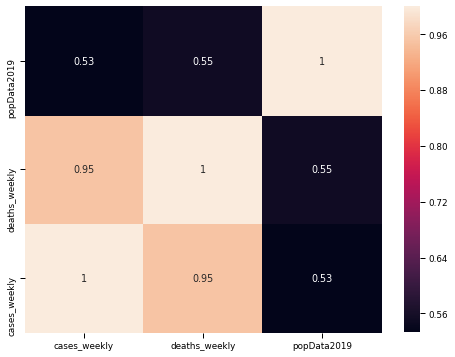

In [93]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6));

sns.heatmap(AsiaCorr, xticklabels = AsiaCorr.columns, yticklabels = AsiaCorr.columns, annot = True);
ax.set_ylim([0,3]);

#Couldn't figure out how to put multiple heatmaps



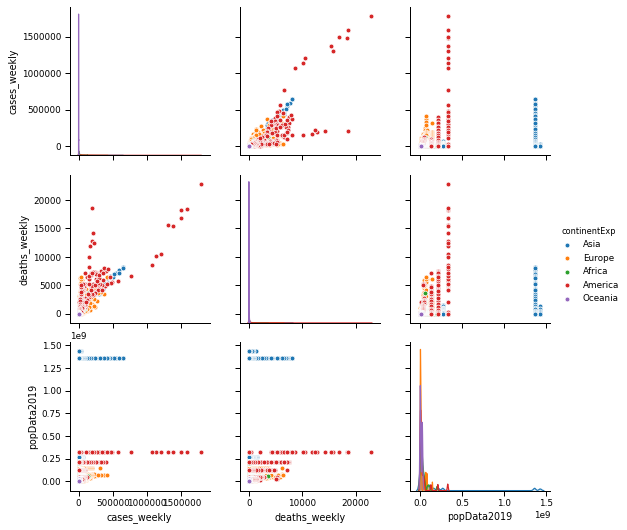

In [94]:
# Pairplot Matrix looking for insight
sns.pairplot(covData, hue='continentExp');


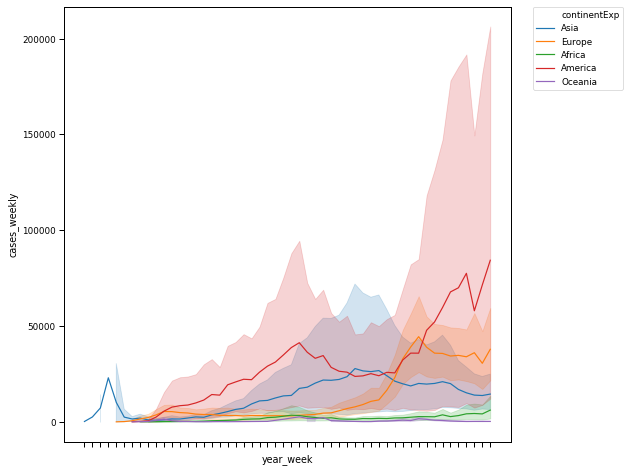

In [95]:
#Overall Trend nonPopulation adjusted
plt.figure(figsize=(8,8))
casewk = sns.lineplot(data=covData, x="year_week", y="cases_weekly", hue="continentExp");
casewk.set_xticklabels(casewk.get_xticklabels(),rotation=45);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [96]:
#Create new metrics to view cases and deaths as population adjusted
covData['casePerMillion'] = (covData['cases_weekly']/covData['popData2019']) * 1000000
covData['deadPerMillion'] = (covData['deaths_weekly']/covData['popData2019']) * 1000000

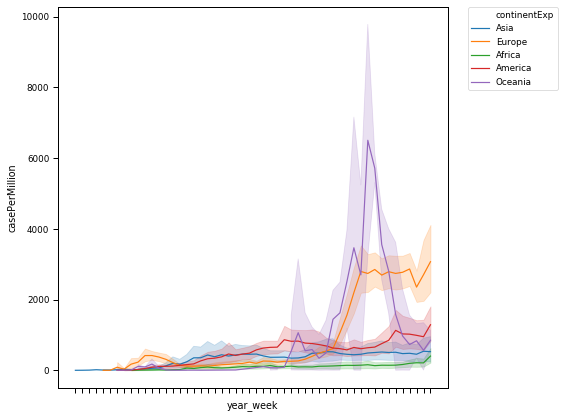

In [97]:
plt.figure(figsize=(7,7));
sns.set_context('paper');
ppg = sns.lineplot(data=covData, x="year_week", y="casePerMillion", hue="continentExp");
ppg.set_xticklabels(ppg.get_xticklabels(),rotation=45,horizontalalignment = 'right');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

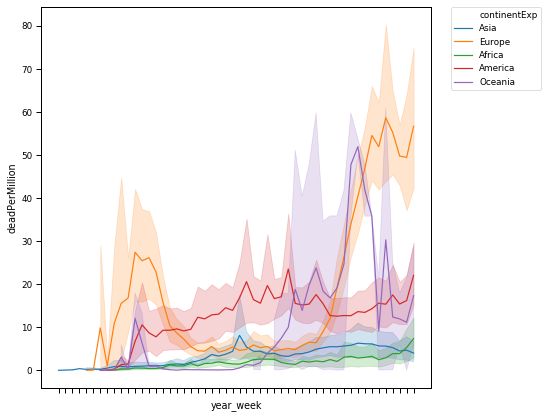

In [98]:
plt.figure(figsize=(7,7));
sns.set_context('paper');
ppg = sns.lineplot(data=covData, x="year_week", y="deadPerMillion", hue="continentExp");
ppg.set_xticklabels(ppg.get_xticklabels(),rotation=45,horizontalalignment = 'right');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [99]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
import numpy
covArr = numpy.reshape(numpy.array(covData['casePerMillion']), (-1, 1))
minMaxScaler = MinMaxScaler()
minMaxRescaledPercentPos = minMaxScaler.fit_transform(covArr)

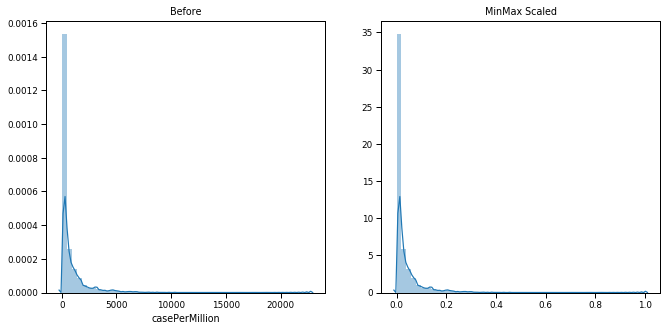

In [100]:
#MinMax Scaling
# Very Long right tail may need log transformation in future.

plt.figure(figsize=(11,11));
plt.subplot(2,2,1);
sns.distplot(covData['casePerMillion']).set_title('Before');

plt.subplot(2,2,2);
sns.distplot(minMaxRescaledPercentPos).set_title('MinMax Scaled');

In [101]:
std_scaler = StandardScaler()
stdRescaledPercentPos = std_scaler.fit_transform(covArr)

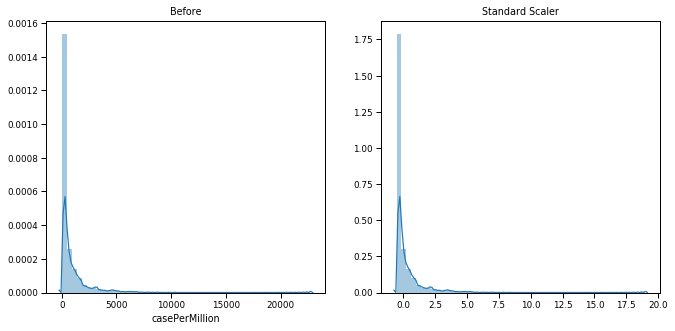

In [102]:
#Standard Scaling
plt.figure(figsize=(11,11));
plt.subplot(2,2,1);
sns.distplot(covData['casePerMillion']).set_title('Before')
plt.subplot(2,2,2);
sns.distplot(stdRescaledPercentPos).set_title('Standard Scaler');